In [ ]:
# Natural Language Intent to Parameterized Function Calls with Phi-3

This notebook explores mapping natural language intent to parameterized function calls with small language models (SLM). This is 
particularly relevant in edge scenarios where latency and/or connectivity issues make the unavailability of cloud-only solutions infeasible.

To make the scenario more concrete, this evaluation considers a use case that has a lot of traction in the automotive industry: 
an an automotive assistant that helps a driver control non-safety critical systems.  It also focuses the investigation around Phi-3 SLM,
but also consider other SLMs (in particular Llama3) and different sizes of Phi-3 (in particular small and medium) to compare and contrast
the baseline performance of Phi-3 mini with these other SLMs.

Finally, it also considers three different implementation techniques.  Namely, it considers:

1. Llama.cpp (via python wrappers / CUDA accelerated) with direct prompts of the LLM.
2. Llama.cpp (via python wrappers / CUDA accelerated) with guidance managed LLM generation.
2. Ollama HTTP endpoint hosted SLMs with direct prompt usage of the LLM to see if there is a performance benefit.
    
There are three main questions this experiment sought to answer:

1. Can Phi-3 accurately map user natural language intents to parameterized function calls? And how does it compare to other SLMs?
2. Can it achieve this with the low latency required for a fluent user experience?
3. How do different backend hosting and implementation techniques affect latency and correctness?

The performance results for this investigation were captured in an WSL2 Ubuntu environment on an AMD 7950X3D desktop PC 
with an Nvidia RTX4080 GPU.  All configurations were configured to use the GPU for acceleration.

This investigation shows that:

1) Yes, this is feasible with the simple single intent commands we consider here. Phi-3 mini is able to map intent to the 
   correct function with the correct parameters at least 95% of the time with 0% incorrect function (but valid function call) mappings
   that cause the most user confusion.
2) With GPU acceleration, it is possible for Phi-3 to do this mapping in P99 subsecond time.
3) Implementation matters a great deal. This investigation shows that utilizing LLM steering libraries like guidance can 
   both greatly accelerate performance (3.1x to 14.2x) and greatly improve successful outcomes (88.3% -> 98.7%).

Finally, there are many avenues where this work could be extended:

1. Extending the investigation to look at more complex natural language commands like 
   "Please lower the temperature to 59 and increase the fan"
   to investigate if Phi-3 can decode these multiple intents into multiple function calls.


In [7]:
import json

with open('results/model-eval-amd-7950x3d-rtx4080.json', 'r') as file:
    data = json.load(file)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

records = []
for model, tools in data.items():
    for tool, metrics in tools.items():
        records.append({
            'model': model,
            'tool': tool,
            'pass_percentage': metrics['pass_percentage'],
            'median_latency': metrics['median_latency'],
            'errors': metrics['errors']
        })

df = pd.DataFrame(records)

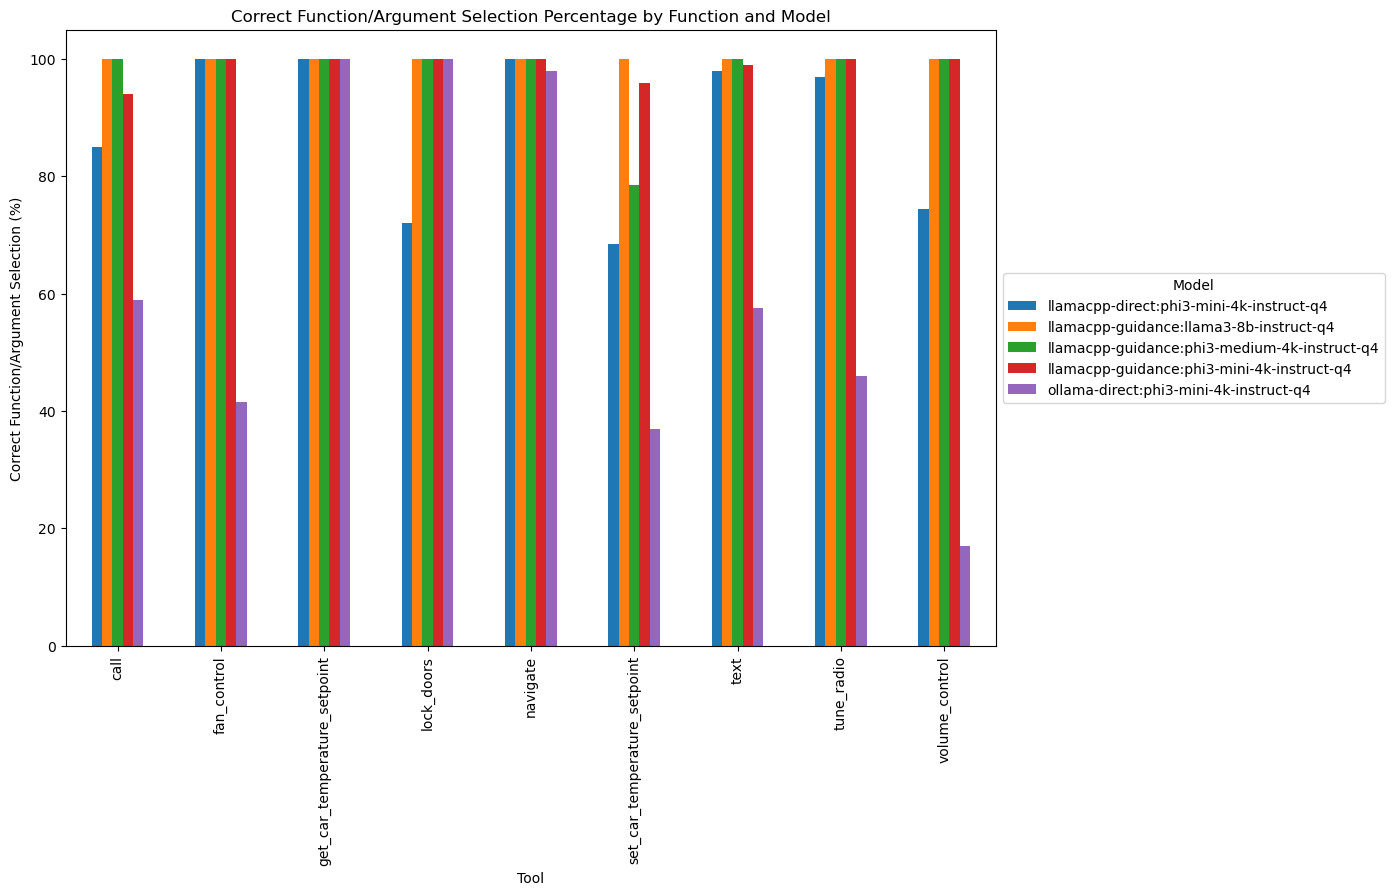

In [15]:

# Pivot the DataFrame to have models as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='model', values='pass_percentage')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Correct Function/Argument Selection Percentage by Function and Model')
plt.xlabel('Tool')
plt.ylabel('Correct Function/Argument Selection (%)')
plt.legend(title='Model', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

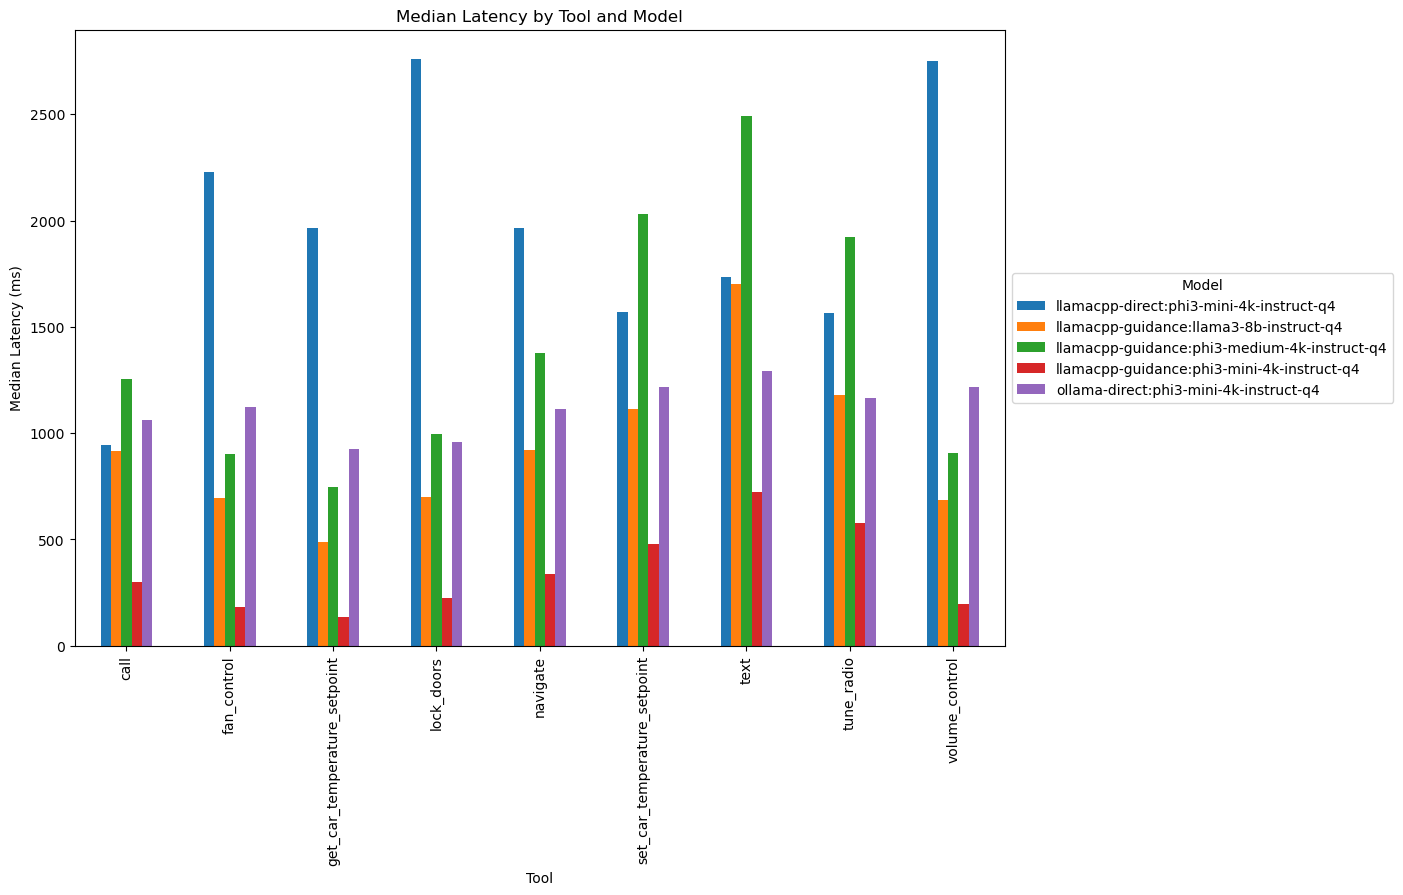

In [10]:
# Pivot the DataFrame to have models as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='model', values='median_latency')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Median Latency by Tool and Model')
plt.xlabel('Tool')
plt.ylabel('Median Latency (ms)')
plt.legend(title='Model', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [8]:
from tabulate import tabulate
from IPython.display import display, HTML

def print_results(results):
    headers = ["f(x)", "p", "fi", "pi", "nfr", "i(bvfc)", "total", "%", "min (ms)", "mean", "median", "max (ms)"]

    data = []
    for pivot in results:
        pivot_results = results[pivot]
        if pivot_results["total_evaluations"] > 0:
            passed = pivot_results["passed"]
            function_incorrect = pivot_results["function_incorrect"]
            parameters_incorrect = pivot_results["parameters_incorrect"]
            non_function_response = pivot_results["non_function_response"]
            total_evaluations = pivot_results["total_evaluations"]
            incorrect_but_valid = pivot_results["incorrect_but_valid"]
            pass_percentage = pivot_results["pass_percentage"]

            min_latency = pivot_results["min_latency"]
            max_latency = pivot_results["max_latency"]
            mean_latency = pivot_results["mean_latency"]
            median_latency = pivot_results["median_latency"]

            data.append([pivot, passed, function_incorrect, parameters_incorrect, non_function_response, incorrect_but_valid, total_evaluations, pass_percentage, min_latency, mean_latency, median_latency, max_latency])  

    print(tabulate(data, headers=headers))
    
for config_tag in data:
    display(HTML(f"<b>{config_tag}</b>"))
    print()
    print_results(data[config_tag])
    print()


f(x)                            p    fi    pi    nfr    i(bvfc)    total    %    min (ms)     mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  ---  ----------  -------  --------  ----------
call                          188     0    12      0          0      200   94   225.416    375.38    299.54      582.02
fan_control                   200     0     0      0          0      200  100   152.119    186.252   184.049     211.63
get_car_temperature_setpoint  200     0     0      0          0      200  100     6.44493  134.181   133.204     175.56
lock_doors                    200     0     0      0          0      200  100   161.99     221.214   223.24      251.534
navigate                      200     0     0      0          0      200  100   215.523    412.86    337.012     782.298
set_car_temperature_setpoint  192     0     8      0          0      200   96   394.87     481.637   480.175     546.578
text                          198 


f(x)                            p    fi    pi    nfr    i(bvfc)    total      %    min (ms)      mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  -----  ----------  --------  --------  ----------
call                          200     0     0      0          0      200  100     986.522    1438.68   1254.32      2091.06
fan_control                   200     0     0      0          0      200  100     428.742     906.351   900.252     1805.36
get_car_temperature_setpoint  200     0     0      0          0      200  100       6.19221   757.099   748.342     1557.52
lock_doors                    200     0     0      0          0      200  100     440.551    1002.05    996.664     2060
navigate                      200     0     0      0          0      200  100     600.634    1553.09   1375.93      2637.86
set_car_temperature_setpoint  157     0    43      0          0      200   78.5  1279.97     2037.8    2029.28      3534.09
text      


f(x)                            p    fi    pi    nfr    i(bvfc)    total    %    min (ms)      mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  ---  ----------  --------  --------  ----------
call                          200     0     0      0          0      200  100     696.567   931.243   917.931    1228.93
fan_control                   200     0     0      0          0      200  100     550.362   695.37    695.696     817.119
get_car_temperature_setpoint  200     0     0      0          0      200  100     306.146   493.427   490.182     631.613
lock_doors                    200     0     0      0          0      200  100     537.277   708.459   701.142     880.038
navigate                      200     0     0      0          0      200  100     656.536   948.739   918.893    1401.51
set_car_temperature_setpoint  200     0     0      0          0      200  100     894.512  1108.1    1111.24     1285.79
text                      


f(x)                            p    fi    pi    nfr    i(bvfc)    total      %    min (ms)     mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  -----  ----------  -------  --------  ----------
call                          170     0    30      0          0      200   85       810.3    1599.85   945.212     2949.84
fan_control                   200     0     0      0          0      200  100      1359.26   1965.12  2229.56      2398.77
get_car_temperature_setpoint  200     0     0      0          0      200  100      1440.38   1831.62  1962.59      2325.17
lock_doors                    144     0     0     56          0      200   72      1024.1    2269.74  2759.37      2935.67
navigate                      200     0     0      0          0      200  100       988.693  1803.02  1962.9       2473.84
set_car_temperature_setpoint  137     0     0     63          0      200   68.5    1490.64   2057.06  1567.84     12540.1
text            


f(x)                            p    fi    pi    nfr    i(bvfc)    total      %    min (ms)      mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  -----  ----------  --------  --------  ----------
call                          118     0    79      3          0      200   59       424.253  1171.23   1061.62     26305.3
fan_control                    83     0   117      0          0      200   41.5     664.579  1138.93   1122.04      1718.01
get_car_temperature_setpoint  200     0     0      0          0      200  100       473.06    862.571   926.919     1045.23
lock_doors                    200     0     0      0          0      200  100       454.134   996.213   957.294     1179.45
navigate                      196     0     4      0          0      200   98       479.113  1102.15   1113.46      1227.66
set_car_temperature_setpoint   74     0   126      0          0      200   37       784.808  1210.94   1216.34      1808.2
text     

In [9]:
from IPython.display import display, HTML

errors_df = df[df['errors'].apply(lambda x: len(x) > 0)]
headers = ["user", "exp f(x)", "gen f(x)", "exp params", "gen params"]

for index, row in errors_df.iterrows():
    model_name = row['model']
    tool_name = row['tool']
    errors = row['errors']

    display(HTML(f"<b>Errors analysis for {tool_name} with config {model_name}</b>"))
    
    errors_table = []
    for error in errors:
        print()
        user_input = error["user_input"]
        
        expected_function = error["expected_function"]
        generated_function = error["generated_function"]
        
        if expected_function != generated_function:
            print(f"{user_input} -> expected f(x) {expected_function} vs. generated {generated_function}")

        expected_parameters = error["expected_parameters"]
        generated_parameters = error["generated_parameters"]
        
        if expected_parameters != generated_parameters:
            print(f'"{user_input}"')
            print(f"expected params:  {expected_parameters}")
            print(f"generated params: {generated_parameters}")

    print()
        


"Please call Elena Ramirez"
expected params:  {'name': 'Elena Ramirez'}
generated params: {'name': 'Elena Ramireezz'}

"Please call Elena Ramirez"
expected params:  {'name': 'Elena Ramirez'}
generated params: {'name': 'Elena Ramireezz'}

"Please call Elena Ramirez"
expected params:  {'name': 'Elena Ramirez'}
generated params: {'name': 'Elena Ramireezz'}

"Please call Elena Ramirez"
expected params:  {'name': 'Elena Ramirez'}
generated params: {'name': 'Elena Ramireezz'}

"Please call Elena Ramirez"
expected params:  {'name': 'Elena Ramirez'}
generated params: {'name': 'Elena Ramireezz'}

"Please call Elena Ramirez"
expected params:  {'name': 'Elena Ramirez'}
generated params: {'name': 'Elena Ramireezz'}

"Please call Elena Ramirez"
expected params:  {'name': 'Elena Ramirez'}
generated params: {'name': 'Elena Ramireezz'}

"Please call Elena Ramirez"
expected params:  {'name': 'Elena Ramirez'}
generated params: {'name': 'Elena Ramireezz'}

"Please call Elena Ramirez"
expected params:  {


"Could you adjust the thermostat to 62 degrees, please?"
expected params:  {'temperature': 62}
generated params: {'temperature': 1.0}

"Can you make it 69 degrees?"
expected params:  {'temperature': 69}
generated params: {'temperature': 19.0}

"Set the air conditioner to 70 degrees."
expected params:  {'temperature': 70}
generated params: {'temperature': 2.0}

"Set the air conditioner to 67 degrees."
expected params:  {'temperature': 67}
generated params: {'temperature': 2.0}

"Set the air conditioner to 71 degrees."
expected params:  {'temperature': 71}
generated params: {'temperature': 2.0}

"Set the air conditioner to 72 degrees."
expected params:  {'temperature': 72}
generated params: {'temperature': 2.0}

"Could you adjust the thermostat to 62 degrees, please?"
expected params:  {'temperature': 62}
generated params: {'temperature': 1.0}

"Can you make it 69 degrees?"
expected params:  {'temperature': 69}
generated params: {'temperature': 19.0}




"Please text Elena Ramirez that I am almost there"
expected params:  {'name': 'Elena Ramirez', 'message': 'I am almost there'}
generated params: {'name': 'Elena Ramiree', 'message': 'I am almost there'}

"Please text Elena Ramirez that I am almost there"
expected params:  {'name': 'Elena Ramirez', 'message': 'I am almost there'}
generated params: {'name': 'Elena Ramiree', 'message': 'I am almost there'}




"Can you please set it to 68 degrees?"
expected params:  {'temperature': 68}
generated params: {'temperature': 680.0}

"Set it at 72 degrees, thanks."
expected params:  {'temperature': 72}
generated params: {'temperature': 720.0}

"Could you adjust the thermostat to 75 degrees, please?"
expected params:  {'temperature': 75}
generated params: {'temperature': 750.0}

"Set the temperature to 59 degrees please"
expected params:  {'temperature': 59}
generated params: {'temperature': 590.0}

"Could you adjust the thermostat to 72 degrees, please?"
expected params:  {'temperature': 72}
generated params: {'temperature': 720.0}

"Please set it to 75 degrees."
expected params:  {'temperature': 75}
generated params: {'temperature': 750.0}

"Please set it to 73 degrees."
expected params:  {'temperature': 73}
generated params: {'temperature': 730.0}

"Can you adjust it to 69 degrees?"
expected params:  {'temperature': 69}
generated params: {'temperature': 690.0}

"Can you make it 69 degrees?"
expe


"Please call Maris"
expected params:  {'name': 'Maris'}
generated params: [{'name': 'name', 'value': 'Maris'}]

"Please call Elena Ramirez"
expected params:  {'name': 'Elena Ramirez'}
generated params: {'name': 'Elena Ramiree'}

"Please call Elena Ramirez"
expected params:  {'name': 'Elena Ramirez'}
generated params: {'name': 'Elena Ramiree'}

"Please call Maris"
expected params:  {'name': 'Maris'}
generated params: [{'name': 'name', 'value': 'Maris'}]

"Please call Elena Ramirez"
expected params:  {'name': 'Elena Ramirez'}
generated params: {'name': 'Elena Ramiree'}

"Please call Eva"
expected params:  {'name': 'Eva'}
generated params: [{'name': 'name', 'value': 'Eva'}]

"Please call Eva"
expected params:  {'name': 'Eva'}
generated params: [{'name': 'name', 'value': 'Eva'}]

"Please call Eva"
expected params:  {'name': 'Eva'}
generated params: [{'name': 'name', 'value': 'Eva'}]

"Please call Elena Ramirez"
expected params:  {'name': 'Elena Ramirez'}
generated params: {'name': 'Elena 


"Please text Elena Ramirez that I am on my way"
expected params:  {'name': 'Elena Ramirez', 'message': 'I am on my way'}
generated params: {'name': 'Elena Ramiree', 'message': 'I am on my way'}

"Please text Elena Ramirez that I am almost there"
expected params:  {'name': 'Elena Ramirez', 'message': 'I am almost there'}
generated params: {'name': 'Elena Ramiree', 'type': 'string', 'message': 'I am almost there'}

"Please text Elena Ramirez that I am almost there"
expected params:  {'name': 'Elena Ramirez', 'message': 'I am almost there'}
generated params: {'name': 'Elena Ramiree', 'type': 'string', 'message': 'I am almost there'}

"Please text Elena Ramirez that I am running behind"
expected params:  {'name': 'Elena Ramirez', 'message': 'I am running behind'}
generated params: {'name': 'Elena Ramiree', 'message': 'I am running behind'}




"Change the radio to The Beach"
expected params:  {'station': 'The Beach'}
generated params: [{'name': 'station', 'type': 'string', 'value': 'The Beach'}]




"Please call Anne"
expected params:  {'name': 'Anne'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Anne'}]

"Please call Theo"
expected params:  {'name': 'Theo'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Theo'}]

"Please call Elena Ramirez"
expected params:  {'name': 'Elena Ramirez'}
generated params: {'name': 'Elena Ramireezz'}

"Please call Jovan"
expected params:  {'name': 'Jovan'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Jovan'}]

"Please call Lila"
expected params:  {'name': 'Lila'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Lila'}]

"Please call Nadia Petrova"
expected params:  {'name': 'Nadia Petrova'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Nadia Petrova'}]

"Please call Anne"
expected params:  {'name': 'Anne'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Anne'}]

"Please call Elena Ramirez"
expected params:  {'name': 'Elena Ramirez'}
generated params


"Full fan please"
expected params:  {'level': 'max'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['max']}]

"Decrease fan speed"
expected params:  {'level': 'decrease'}
generated params: [{'name': 'decrease', 'type': 'string'}]

"Increase the fan please"
expected params:  {'level': 'increase'}
generated params: [{'name': 'increase', 'type': 'string'}]

"Turn off fan"
expected params:  {'level': 'off'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['off']}]

"Decrease fan speed"
expected params:  {'level': 'decrease'}
generated params: [{'name': 'decrease', 'type': 'string'}]

"Full fan please"
expected params:  {'level': 'max'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['max']}]

"Set fan to full"
expected params:  {'level': 'max'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['max']}]

"Turn off fan"
expected params:  {'level': 'off'}
generated params: [{'name': 'level',


"Navigate me to the nearest ATM"
expected params:  {'destination': 'the nearest ATM'}
generated params: [{'name': 'destination', 'type': 'string', 'value': 'nearest ATM'}]

"Navigate me to the nearest gas station"
expected params:  {'destination': 'the nearest gas station'}
generated params: [{'name': 'destination', 'type': 'string', 'value': 'nearest gas station'}]

"Navigate me to the nearest ATM"
expected params:  {'destination': 'the nearest ATM'}
generated params: [{'name': 'destination', 'type': 'string', 'value': 'nearest ATM'}]

"Navigate me to SFO"
expected params:  {'destination': 'SFO'}
generated params: {'destination': 'San Francisco International Airport (SFO)'}




"Could you set the thermostat to 70 degrees?"
expected params:  {'temperature': 70}
generated params: [{'name': 'temperature', 'type': 'float'}]

"I’d like the temperature at 71 degrees, please."
expected params:  {'temperature': 71}
generated params: [{'name': 'temperature', 'type': 'float'}]

"Set the thermostat to 71 degrees, please."
expected params:  {'temperature': 71}
generated params: [{'name': 'temperature', 'type': 'float'}]

"Could you make the temperature 61 degrees?"
expected params:  {'temperature': 61}
generated params: [{'name': 'temperature', 'type': 'float'}]

"Could you adjust the thermostat to 62 degrees, please?"
expected params:  {'temperature': 62}
generated params: [{'name': 'temperature', 'type': 'float'}]

"Can you change the temperature to 64 degrees?"
expected params:  {'temperature': 64}
generated params: [{'name': 'temperature', 'type': 'float'}]

"Adjust the temperature to 71 degrees, please."
expected params:  {'temperature': 71}
generated params: [{'na


"Please text Jovan that I am stuck in traffic"
expected params:  {'name': 'Jovan', 'message': 'I am stuck in traffic'}
generated params: [{'name': 'name', 'type': 'string', 'allowed_values': ['Jovan']}, {'name ': 'message', 'type': 'string', 'value': 'I am stuck in traffic'}]

"Please text Eva that I am almost there"
expected params:  {'name': 'Eva', 'message': 'I am almost there'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Eva'}, {'name': 'message', 'type': 'string', 'value': 'I am almost there'}]

"Please text Ben that I will be there soon"
expected params:  {'name': 'Ben', 'message': 'I will be there soon'}
generated params: [{'name': 'name', 'value': 'Ben'}, {'name': 'message', 'value': 'I will be there soon'}]

"Please text Anne that I am running late"
expected params:  {'name': 'Anne', 'message': 'I am running late'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Anne'}, {'name': 'message', 'type': 'string', 'value': 'I am running late'}]

"


"Can you switch the radio to 100.3?"
expected params:  {'station': 100.3}
generated params: [{'name': 'station', 'type': 'string'}]

"Please tune to 97.9 on the radio"
expected params:  {'station': 97.9}
generated params: [{'name': 'station', 'type': 'string', 'value': '97.9'}]

"Could you set the radio to 102.3 for me, please?"
expected params:  {'station': 102.3}
generated params: [{'name': 'station', 'type': 'string', 'value': '102.3'}]

"Could you dial in the radio to 100.3 for me?"
expected params:  {'station': 100.3}
generated params: [{'name': 'station', 'type': 'string', 'value': '100.3'}]

"Please tune to 98.5 on the radio"
expected params:  {'station': 98.5}
generated params: [{'name': 'station', 'type': 'string', 'value': '98.5'}]

"Change the radio to 103.1"
expected params:  {'station': 103.1}
generated params: [{'name': 'station', 'type': 'string', 'allowed_values': ['102.5', '98.7', '103.1']}]

"Could you dial in the radio to 101.7 for me?"
expected params:  {'station':


"Decrease volume"
expected params:  {'volume': 'decrease'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['decrease']}]

"Please turn up the volume"
expected params:  {'volume': 'increase'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['increase']}]

"Decrease volume"
expected params:  {'volume': 'decrease'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['decrease']}]

"Decrease volume"
expected params:  {'volume': 'decrease'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['decrease']}]

"Mute audio"
expected params:  {'volume': 'mute'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['mute']}]

"Set volume to 15"
expected params:  {'volume': '15'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['increase', 'decrease', 'mute', '15', '30', '45']}]

"Decrease volume"
expected params:  {'volume': 'decrease'}
generated params

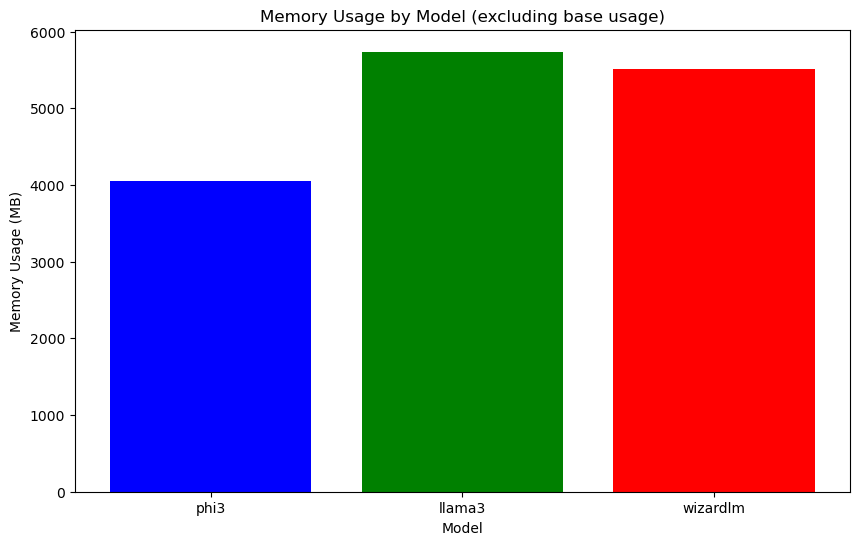

In [10]:
# Base memory usage
base_memory_usage = 1889 # MB

# Compute gross memory measurements with nvidia-smi minus base usage
phi3_memory_usage = 5935 - base_memory_usage # MB
llama3_memory_usage = 7626 - base_memory_usage # MB
wizardlm_memory_usage = 7403 - base_memory_usage # MB

# Data for plotting
models = ['phi3', 'llama3', 'wizardlm']
memory_usage = [phi3_memory_usage, llama3_memory_usage, wizardlm_memory_usage]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, memory_usage, color=['blue', 'green', 'red'])

plt.title('Memory Usage by Model (excluding base usage)')
plt.xlabel('Model')
plt.ylabel('Memory Usage (MB)')
plt.show()

In [28]:
with open('results/tool-count-eval-m1-max.json', 'r') as file:
    data = json.load(file)

In [29]:
records = []

for tool_count, tools in data.items():
    for tool, metrics in tools.items():
        records.append({
            'tool_count': tool_count,
            'tool': tool,
            'median_latency': metrics['median_latency'],
            'pass_percentage': metrics['pass_percentage'],
        })

df = pd.DataFrame(records)

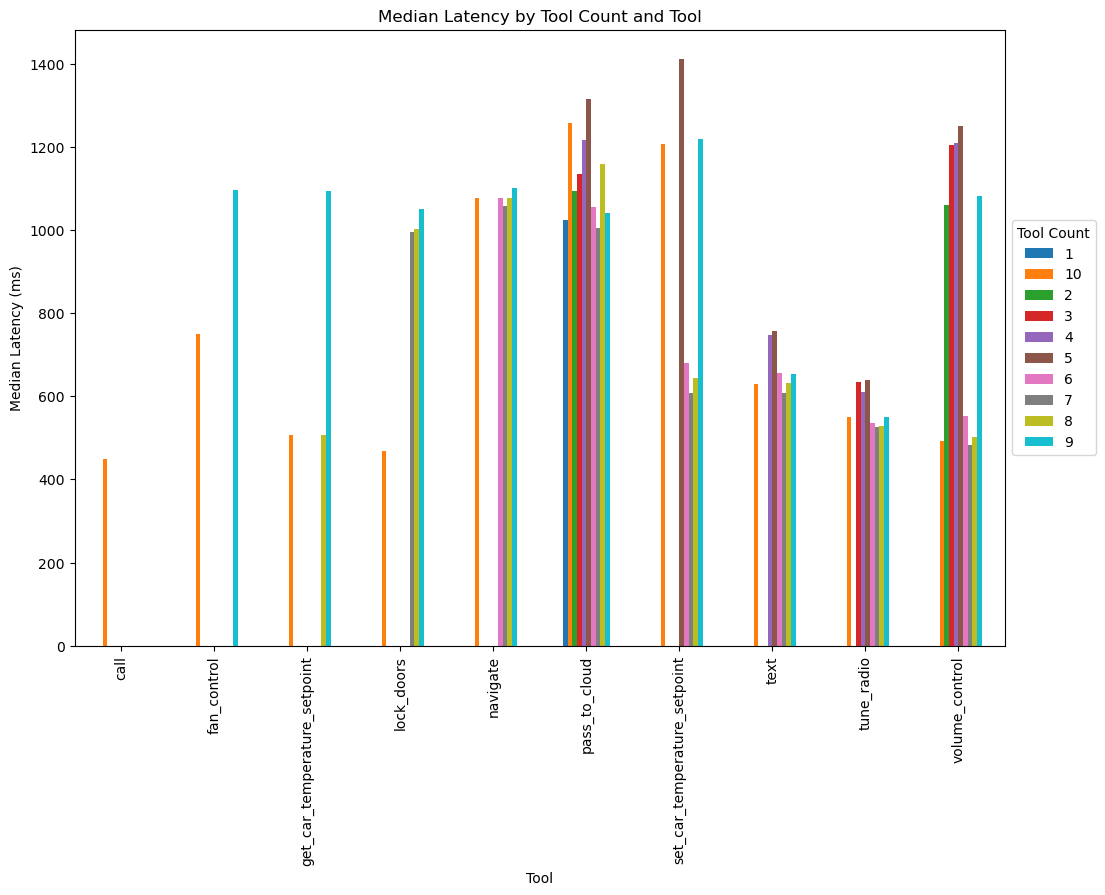

In [30]:
# Pivot the DataFrame to have tool counts as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='tool_count', values='median_latency')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Median Latency by Tool Count and Tool')
plt.xlabel('Tool')
plt.ylabel('Median Latency (ms)')
plt.legend(title='Tool Count', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

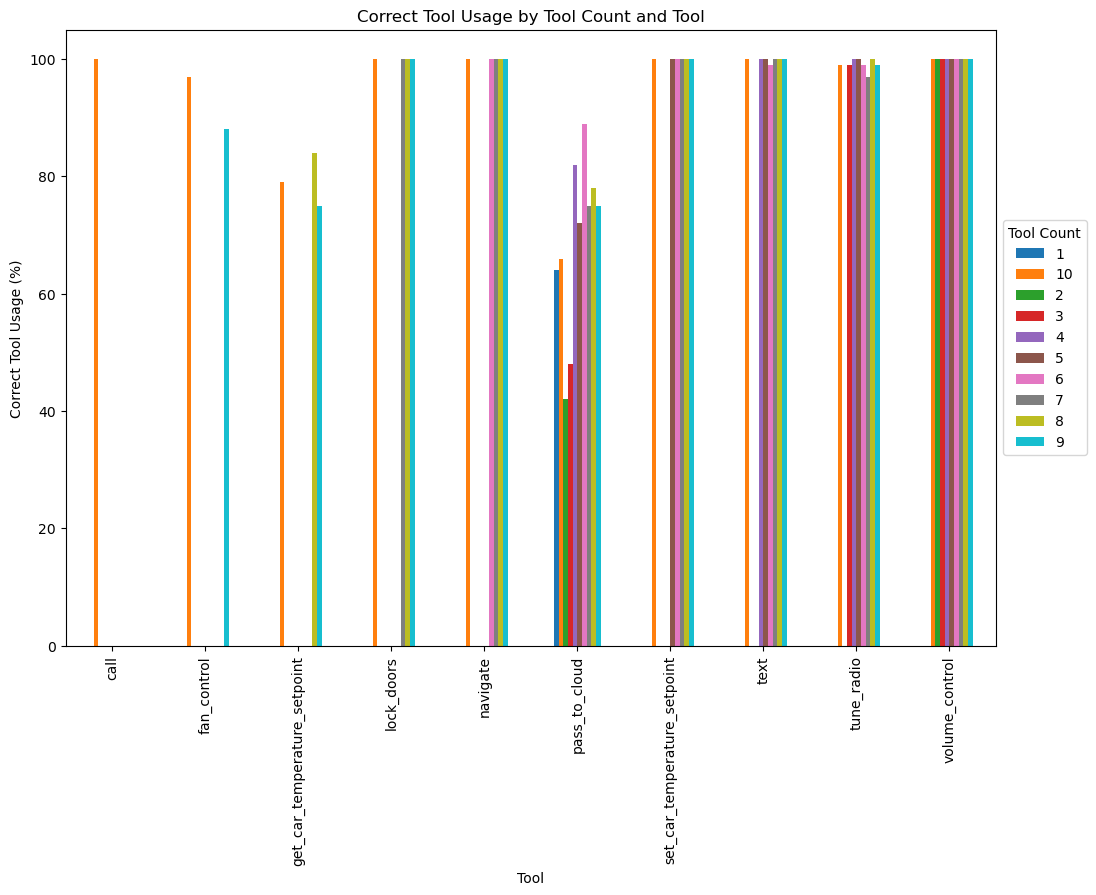

In [31]:
pivot_df = df.pivot(index='tool', columns='tool_count', values='pass_percentage')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Correct Tool Usage by Tool Count and Tool')
plt.xlabel('Tool')
plt.ylabel('Correct Tool Usage (%)')
plt.legend(title='Tool Count', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

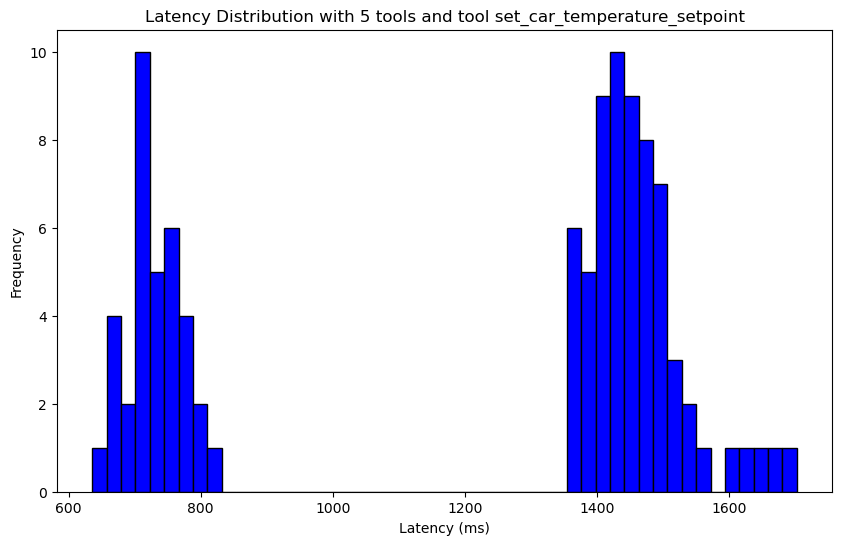

In [32]:
import numpy as np
import matplotlib.pyplot as plt

tool_count = '5'
tool_name = 'set_car_temperature_setpoint'

five_tool_count = data[tool_count]
latencies = five_tool_count[tool_name]['latencies']

# Create bins for the histogram
min_latency = min(latencies)
max_latency = max(latencies)
bins = np.linspace(min_latency, max_latency, 50)

# Plotting the latency distribution
plt.figure(figsize=(10, 6))
plt.hist(latencies, bins=bins, edgecolor='black', color='blue')

plt.title(f'Latency Distribution with {tool_count} tools and tool {tool_name}')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Are there user inputs that are more likely to fail?
# How does hardware effect latency (4800 vs. M1 Max vs M4)?